## Plot the locations of all profiles

In [1]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import json
import numpy as np
import xarray as xr
import os

import numpy as np
import dask
import xarray as xr
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import glob as glob
import time
from datetime import date
import io
import json


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/dask/config.py:168: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  data = yaml.load(f.read()) or {}


In [2]:
def get_netcdf_profiles(netcdf_name):

    dsprof=xr.open_dataset(netcdf_name)
    depth=dsprof['depth_en4']
    temp_en4=dsprof['temp_profileEN4']
    salt_en4=dsprof['salt_profileEN4']
    mean_temp_model=dsprof['mean_temp_model']
    mean_salt_model=dsprof['mean_salt_model']

    return depth,temp_en4,salt_en4,mean_temp_model,mean_salt_model

In [3]:
def map_profiles_from_jsonfile(all_lat1,all_lon1,all_lat2,all_lon2,all_lat3,all_lon3,reg):
    
    if reg == 'EU':
        fig, ax = plt.subplots(1,1,figsize=(10,15))
        latmin,latmax,lonmin,lonmax=(32.6,65.6,-19,10)
        maskfile='/store/colombo/EU36/EU36-I/EU36.L75_mesh_mask.nc'

    if reg == 'GS':
        fig, ax = plt.subplots(1,1,figsize=(15,10))
        latmin,latmax,lonmin,lonmax=(27,48,-81,-35)
        maskfile='/scratch/cnt0024/hmg2840/albert7a/GS36.L75/GS36.L75-I/GS36.L75-MAA007_mesh_mask.nc'


    mask=xr.open_dataset(maskfile)
    tmask=mask.tmask[0,0]
    navlat= mask['nav_lat']
    navlon= mask['nav_lon']
    ax = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=0))
    ax.set_extent((lonmin, lonmax, latmin, latmax))
    ax.contour(navlon,navlat,tmask,alpha=0.5,linewidth=0.000001,antialiased=True,colors='black')
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.tick_params('both',labelsize=22)

    all_lon=0*all_lon1
    all_lat=0*all_lat1
    all_lon12=0*all_lon1
    all_lat12=0*all_lat1
    all_lon23=0*all_lon1
    all_lat23=0*all_lat1
    all_lon13=0*all_lon1
    all_lat13=0*all_lat1
    all_lon_only1=1*all_lon1
    all_lat_only1=1*all_lat1
    all_lon_only2=1*all_lon2
    all_lat_only2=1*all_lat2
    all_lon_only3=1*all_lon3
    all_lat_only3=1*all_lat3
    
    for k in np.arange(len(all_lon1)):
        if all_lon1[k]!= 0:
            if all_lon1[k] in all_lon2 and all_lat1[k] in all_lat2 and all_lon1[k] in all_lon3 and all_lat1[k] in all_lat3:
                all_lon[k]=all_lon1[k]
                all_lat[k]=all_lat1[k]
                all_lon_only1[k]=0
                all_lat_only1[k]=0
                all_lon_only2[k]=0
                all_lat_only2[k]=0
                all_lon_only3[k]=0
                all_lat_only3[k]=0
            if all_lon1[k] in all_lon2 and all_lat1[k] in all_lat2 and all_lon1[k] not in all_lon3 and all_lat1[k] not in all_lat3:
                all_lon12[k]=all_lon1[k]
                all_lat12[k]=all_lat1[k]
                all_lon_only1[k]=0
                all_lat_only1[k]=0
                all_lon_only2[k]=0
                all_lat_only2[k]=0
            if all_lon1[k] in all_lon3 and all_lat1[k] in all_lat3 and all_lon1[k] not in all_lon2 and all_lat1[k] not in all_lat2:
                all_lon13[k]=all_lon1[k]
                all_lat13[k]=all_lat1[k]
                all_lon_only1[k]=0
                all_lat_only1[k]=0
                all_lon_only3[k]=0
                all_lat_only3[k]=0
        if all_lon1[k]== 0 and all_lon2[k]!=0:
            if all_lon2[k] in all_lon3 and all_lat2[k] in all_lat3 and all_lon2[k] not in all_lon1 and all_lat2[k] not in all_lat1:
                all_lon23[k]=all_lon2[k]
                all_lat23[k]=all_lat2[k]
                all_lon_only2[k]=0
                all_lat_only2[k]=0
                all_lon_only3[k]=0
                all_lat_only3[k]=0
                
    plt.scatter(all_lon, all_lat, c='k', linewidth='0', s=18, label='all simus');
    plt.scatter(all_lon12, all_lat12, c='m', linewidth='0', s=18, label='75 and 150surf');
    plt.scatter(all_lon13, all_lat13, c='brown', linewidth='0', s=18, label='75 and 150arctan');
    plt.scatter(all_lon23, all_lat23, c='gold', linewidth='0', s=18, label='150 surf and arctan');
    plt.scatter(all_lon1, all_lat1, c='r', linewidth='0', s=18, label='75 only');
    plt.scatter(all_lon2, all_lat2, c='b', linewidth='0', s=18, label='150surf only');
    plt.scatter(all_lon3, all_lat3, c='g', linewidth='0', s=18, label='150arctan only');
    plt.title('EN4 profiles in '+reg+' region in 2012-2013 dep>1000', size=20);
    plt.savefig('profiles_'+reg+'_period_NATL60_over1000m_all_simus.png')


In [4]:
def concat_lat_lon_dep1000m(reg,case):

    if reg == 'EU':
        config='EU36'
    if reg == 'GS':
        config='GS36'
        
    namezone='NATL60-CJM165_'+reg+'_y2012-2013'
    jsonfile='/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_'+reg+'_y2012-2013/NATL60-CJM165_'+reg+'_y2012-2013_final.json'
    dirn='/scratch/cnt0024/hmg2840/albert7a/EN4/profiles_files/NATL60-CJM165_'+reg+'_y2012-2013/'+config+'-'+case+'/'    

    sourcefile=open(jsonfile,'rU',encoding='utf-8')
    infos=json.load(sourcefile)
    nb_profilesEN4=len(infos)
    list_profiles=infos.keys()

    all_lat=np.zeros((nb_profilesEN4))
    all_lon=np.zeros((nb_profilesEN4))
    nb=0
    for prof in np.arange(nb_profilesEN4):
        reference =  str(list(list_profiles)[prof])
        reference_profile=reference[-16:-1]
        outname=dirn+"/profiles_EN4-"+reference_profile+"_"+config+"-"+case+"_TS_vert-stand.nc"
        if os.path.exists(outname):
            depth,temp_en4,salt_en4,mean_temp_model,mean_salt_model = get_netcdf_profiles(outname)
            ien4t=np.where(np.isnan(temp_en4)==True)
            ien4s=np.where(np.isnan(salt_en4)==True)
            imodt=np.where(np.isnan(mean_temp_model)==True)
            imods=np.where(np.isnan(mean_salt_model)==True)
            if len(imodt[:][0])>0:
                dep_modt=depth[np.min(imodt[:][0])].values
            else:
                dep_modt=2000
            if len(imods[:][0])>0:
                dep_mods=depth[np.min(imods[:][0])].values
            else:
                dep_mods=2000
            if len(ien4t[:][0]) >0: 
                dept=depth[np.min(ien4t[:][0])].values
            else:
                dept=2000
            
            if len(ien4s[:][0]) >0:
                deps=depth[np.min(ien4s[:][0])].values
            else:
                deps=2000
                
            if dept>1000 and deps>1000:
                if dept == 2000:
                    ecart=110
                else:
                    ecart=10
                if np.abs(dept-dep_modt)<ecart and np.abs(deps-dep_mods)<ecart:
                    nb=nb+1
                    lat_prof = infos[reference]['latitude']
                    lon_prof = infos[reference]['longitude']
                    all_lat[prof]=lat_prof
                    all_lon[prof]=lon_prof
    return all_lat,all_lon,nb
    


In [5]:
all_lat_EU1,all_lon_EU1,nb_EU1=concat_lat_lon_dep1000m('EU','MPC001')
print(nb_EU1)


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 'U' mode is deprecated
  if sys.path[0] == '':


509


In [6]:
all_lat_EU2,all_lon_EU2,nb_EU2=concat_lat_lon_dep1000m('EU','MPC002')
print(nb_EU2)


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 'U' mode is deprecated
  if sys.path[0] == '':


438


In [7]:
all_lat_EU3,all_lon_EU3,nb_EU3=concat_lat_lon_dep1000m('EU','MPC003')
print(nb_EU3)


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: DeprecationWarning: 'U' mode is deprecated
  if sys.path[0] == '':


739


/scratch/cnt0024/hmg2840/albert7a/anaconda3/lib/python3.7/site-packages/cartopy/mpl/geoaxes.py:1366: UserWarning: The following kwargs were not used by contour: 'linewidth'
  result = matplotlib.axes.Axes.contour(self, *args, **kwargs)


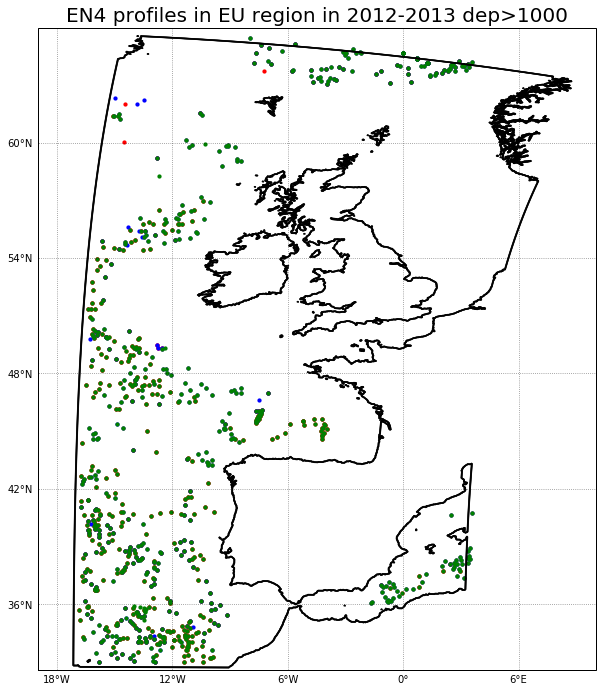

In [8]:
map_profiles_from_jsonfile(all_lat_EU1,all_lon_EU1,all_lat_EU2,all_lon_EU2,all_lat_EU3,all_lon_EU3,'EU')
    

In [10]:
all_lat1,all_lon1,all_lat2,all_lon2,all_lat3,all_lon3,reg=all_lat_EU1,all_lon_EU1,all_lat_EU2,all_lon_EU2,all_lat_EU3,all_lon_EU3,'EU'

In [24]:
def map_profiles_from_jsonfile(all_lat,all_lon,reg,case,color):
    
    if reg == 'EU':
        fig, ax = plt.subplots(1,1,figsize=(10,15))
        latmin,latmax,lonmin,lonmax=(32.6,65.6,-17,10)
        maskfile='/store/colombo/EU36/EU36-I/EU36.L75_mesh_mask.nc'

    if reg == 'GS':
        fig, ax = plt.subplots(1,1,figsize=(15,10))
        latmin,latmax,lonmin,lonmax=(27,48,-81,-40)
        maskfile='/scratch/cnt0024/hmg2840/albert7a/GS36.L75/GS36.L75-I/GS36.L75-MAA007_mesh_mask.nc'


    mask=xr.open_dataset(maskfile)
    tmask=mask.tmask[0,0]
    navlat= mask['nav_lat']
    navlon= mask['nav_lon']
    ax = plt.subplot(111,projection=ccrs.PlateCarree(central_longitude=0))
    ax.set_extent((lonmin, lonmax, latmin, latmax))
    ax.contour(navlon,navlat,tmask,alpha=0.5,linewidth=0.000001,antialiased=True,colors='black')
    gl = ax.gridlines(draw_labels=True, linestyle=':', color='black',
                      alpha=0.5)
    gl.xlabels_top = False
    gl.ylabels_right = False
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    ax.tick_params('both',labelsize=22)

    plt.scatter(all_lon, all_lat, c=color, linewidth='0', s=18);
    plt.title('EN4 profiles in '+reg+'36 '+case+' in 2012-2013 dep>1000', size=20);
    plt.savefig('profiles_'+reg+'36-'+case+'_period_NATL60_over1000m.png')


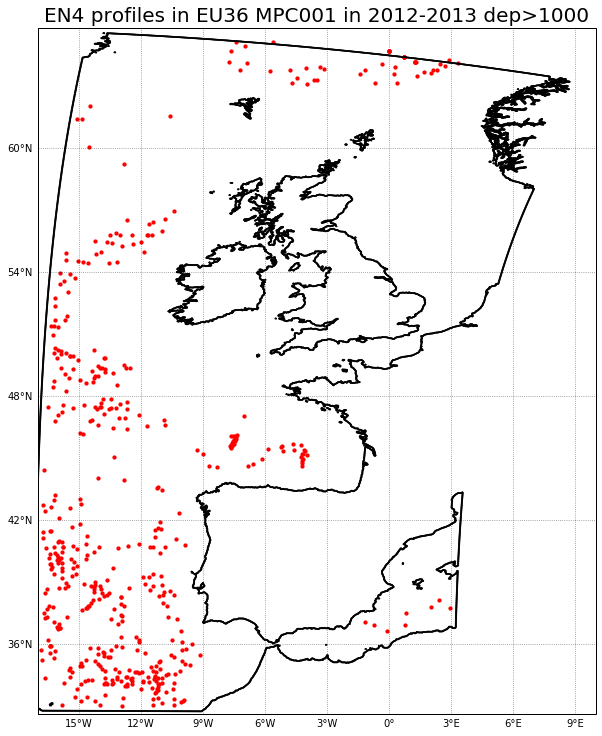

In [25]:
map_profiles_from_jsonfile(all_lat1,all_lon1,'EU','MPC001','r')

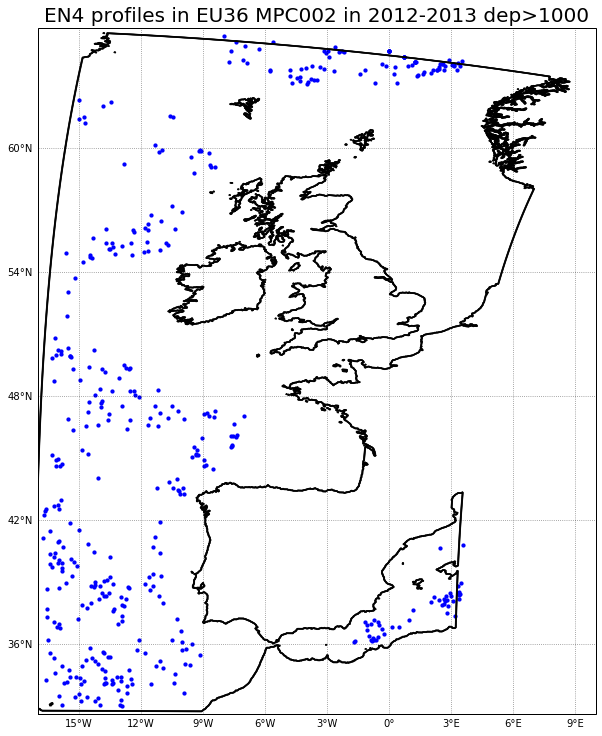

In [28]:
map_profiles_from_jsonfile(all_lat2,all_lon2,'EU','MPC002','b')

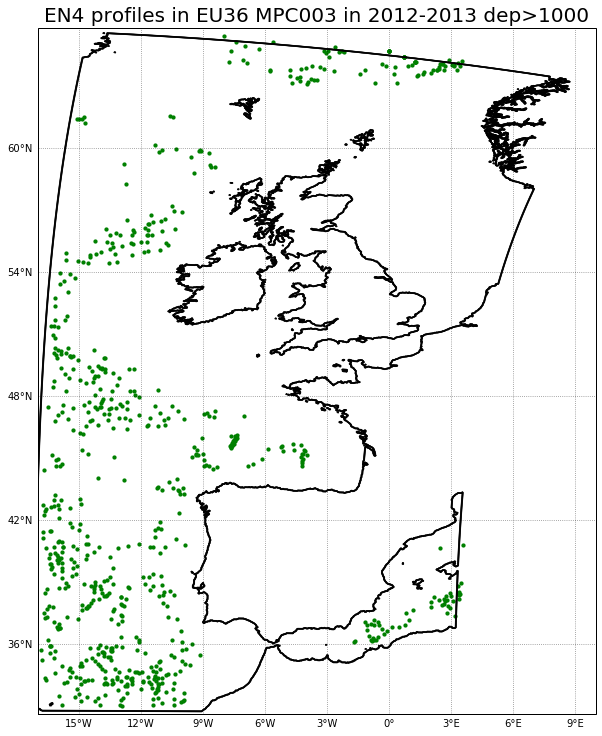

In [29]:
map_profiles_from_jsonfile(all_lat3,all_lon3,'EU','MPC003','g')